In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mbptycho.code.simulation import reloadSimulation
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
from matplotlib.colors import LogNorm, SymLogNorm, Normalize, LinearSegmentedColormap
from skimage.registration import phase_cross_correlation
from matplotlib import ticker
from scipy.stats import circmean

import copy
import os
base_path = os.environ['HOME']

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks/'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

In [5]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


((200, 200, 20), 0.005841818181818182)

In [115]:
def calc_error(img1, img2):
    src_freq = np.fft.fftn(img1)
    target_freq = np.fft.fftn(img2)
    src_amp = np.sum(np.real(src_freq * src_freq.conj()))
    src_amp /= src_freq.size
    target_amp = np.sum(np.real(target_freq * target_freq.conj()))
    target_amp /= target_freq.size
    
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifftn(image_product)
    maxima = np.unravel_index(np.argmax(np.abs(cross_correlation)),
                              cross_correlation.shape)
    error = 1.0 - cross_correlation[maxima] * cross_correlation[maxima].conj() / (src_amp * target_amp)
    return np.sqrt(np.abs(error))

In [7]:
recons_separate = {'rho': np.load(f'{data_path}/rho_phase_sep_mags.npz')['arr_0'],
                   'ux': np.load(f'{data_path}/ux_displacement_to_phase.npz')['arr_0'],
                   'uy': np.load(f'{data_path}/uy_displacement_to_phase.npz')['arr_0'],
                   'df': pd.read_pickle(f'{data_path}/df_phase_sep_mags.gz')}

In [8]:
recons_direct = {'rho': np.load(f'{data_path}/direct_no_projection_rho_displacement_to_data_shared_mags.npz')['arr_0'],
                   'ux': np.load(f'{data_path}/direct_no_projection_ux_displacement_to_data_shared_mags.npz')['arr_0'],
                   'uy': np.load(f'{data_path}/direct_no_projection_uy_displacement_to_data_shared_mags.npz')['arr_0'],
                   'df': pd.read_pickle(f'{data_path}/direct_no_projection_df_displacement_to_data_shared_mags.gz')}

In [9]:
recons_proj = {'rho': np.load(f'{data_path}/direct_projected_rho_displacement_to_data_shared_mags.npz')['arr_0'],
                   'ux': np.load(f'{data_path}/direct_projected_ux_displacement_to_data_shared_mags.npz')['arr_0'],
                   'uy': np.load(f'{data_path}/direct_projected_uy_displacement_to_data_shared_mags.npz')['arr_0'],
                   'df': pd.read_pickle(f'{data_path}/direct_projected_df_displacement_to_data_shared_mags.gz')}

In [10]:
recons = DisplacementFullModelReconstruction(simulation=sm, shared_magnitudes=True)

Setting background_level to 1e-08...


In [11]:

true_items = {}

if recons._model_type != 'phase':
    pady0, padx0, nyvar, nxvar, nzvar = [recons.fwd_model._pady0,
                                      recons.fwd_model._padx0,
                                      recons.fwd_model._npix_y,
                                      recons.fwd_model._npix_x,
                                      recons.fwd_model._npix_z]

    ux_true = sm.sample.Ux_trunc[..., 10].copy()
    ux_true[~sm.sample.magnitudes_trunc_mask[..., 10]] = 0
    ux_true = ux_true[pady0: pady0 + nyvar, padx0: padx0 + nxvar] / sm.sample.params.lattice[0]

    uy_true = sm.sample.Uy_trunc[..., 10].copy()
    uy_true[~sm.sample.magnitudes_trunc_mask[..., 10]] = 0
    uy_true = uy_true[pady0: pady0 + nyvar, padx0: padx0 + nxvar] / sm.sample.params.lattice[0]
    true_items['ux'] = ux_true
    true_items['uy'] = uy_true


if not recons._model_type == 'displacement_to_phase':
    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = f"phi{phase_label}"
        
        #rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        #recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])
mask = np.ones_like(ux_true).astype('bool')
mask[5:-5,5:-5] = 0

In [40]:
import skimage

In [87]:
skimage.metrics.structural_similarity(ux_this[5:-5,5:-5].astype('float32'), true_items['ux'][5:-5,5:-5].astype('float32'))

0.981943467773726

0
ux, reg (array([0., 0.]), 0.0, -0.0)
ux, reg2 0.0
ux, nrmse 0.0
ux, ssim 1.0
uy, reg (array([0., 0.]), 1.4901161193847656e-08, -0.0)
uy, reg2 1.8250120749944284e-08
uy, nrmse 0.0
uy, ssim 1.0
1
ux, reg (array([0., 0.]), 0.6445546572661217, -0.0)
ux, reg2 0.6445546486547427
ux, nrmse 0.6964236034712074
ux, ssim 0.37393298417702875
uy, reg (array([1., 0.]), 0.9667745526451912, 1.355399205562086)
uy, reg2 0.9516245403971305
uy, nrmse 1.1137950980565219
uy, ssim -0.05761855464456588
2
ux, reg (array([0., 2.]), 0.9858265795884186, 1.3141044507279687)
ux, reg2 0.9585418870993334
ux, nrmse 1.5035857035838882
ux, ssim 0.01258127798392861
uy, reg (array([1., 1.]), 0.9514707175779961, -0.6446756320911041)
uy, reg2 0.9727674933079072
uy, nrmse 1.479958215374216
uy, ssim 0.09859491490197554
3
ux, reg (array([0., 0.]), 0.03454140013980916, -0.0)
ux, reg2 0.03454164053148466
ux, nrmse 0.035014744245327065
ux, ssim 0.9819434680506488
uy, reg (array([0., 0.]), 0.05131935040250333, -0.0)
uy, reg2 0.0

<ipython-input-128-92769e18a096>:12: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  print('ux, ssim', skimage.metrics.structural_similarity(true_items['ux'][5:-5,5:-5], ux_this[5:-5,5:-5]))
<ipython-input-128-92769e18a096>:26: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  print('uy, ssim', skimage.metrics.structural_similarity(true_items['uy'][5:-5,5:-5], uy_this[5:-5,5:-5]))


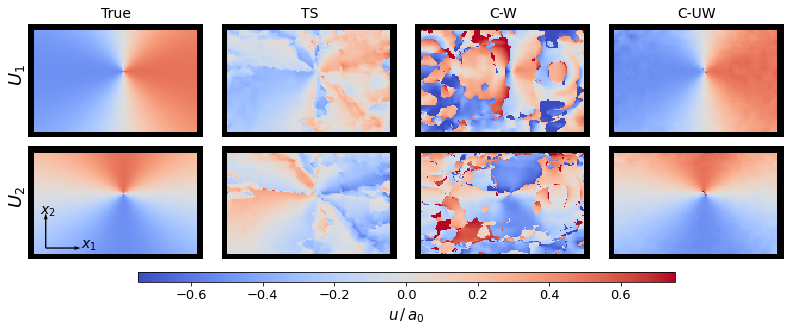

In [128]:
fig, axes = plt.subplots(2, 4, figsize=[11,4.5], constrained_layout=True)


for i, d in enumerate([true_items, recons_separate, recons_direct, recons_proj]):
    ux_diffs = d['ux'] - true_items['ux']
    ux_diffs_mean = ux_diffs[5:-5, 5:-5].mean()
    ux_this = d['ux'] - ux_diffs_mean
    print(i)
    print('ux, reg', phase_cross_correlation( true_items['ux'][5:-5,5:-5], ux_this[5:-5,5:-5], space='fourier'))
    print('ux, reg2', calc_error(ux_this[5:-5,5:-5], true_items['ux'][5:-5,5:-5]))
    print('ux, nrmse', skimage.metrics.normalized_root_mse( true_items['ux'][5:-5,5:-5], ux_this[5:-5,5:-5]))
    print('ux, ssim', skimage.metrics.structural_similarity(true_items['ux'][5:-5,5:-5], ux_this[5:-5,5:-5]))
    ux_this[mask] = np.nan
    cp = axes[0, i].pcolormesh(ux_this, cmap=cmap, vmin=-0.75, vmax=0.75)
    axes[0, i].set_axis_off()
    axes[0,i].set_aspect('equal')
    
    uy_diffs = d['uy'] - true_items['uy']
    uy_diffs_mean = uy_diffs[5:-5, 5:-5].mean()
    uy_this = d['uy'] - uy_diffs_mean
    uy_true = true_items['uy'].copy()
    
    print('uy, reg', phase_cross_correlation( true_items['uy'][5:-5,5:-5], uy_this[5:-5,5:-5], space='fourier'))
    print('uy, reg2', calc_error(uy_this[5:-5,5:-5], true_items['uy'][5:-5,5:-5]))
    print('uy, nrmse', skimage.metrics.normalized_root_mse( true_items['uy'][5:-5,5:-5], uy_this[5:-5,5:-5]))
    print('uy, ssim', skimage.metrics.structural_similarity(true_items['uy'][5:-5,5:-5], uy_this[5:-5,5:-5]))
    uy_this[mask] = np.nan
    cp = axes[1, i].pcolormesh(uy_this, cmap=cmap, vmin=-0.75, vmax=0.75)
    axes[1, i].set_axis_off()
    axes[1, i].set_aspect('equal')

axes[0, 0].set_title('True', fontsize=14)
axes[0, 1].set_title('TS', fontsize=14)
axes[0, 2].set_title('C-W', fontsize=14)
axes[0, 3].set_title('C-UW', fontsize=14)

axes[0, 0].text(-0.12, 0.5, r'$U_1$', fontsize=18, transform=axes[0, 0].transAxes, rotation=90)
axes[1, 0].text(-0.12, 0.5, r'$U_2$', fontsize=18, transform=axes[1, 0].transAxes, rotation=90)


axes[1, 0].quiver(0.1, 0.1, 0., 1, scale=5, color='k', transform=axes[1, 0].transAxes)
axes[1, 0].quiver(0.1, 0.1, 1., 0, scale=5, color='k', transform=axes[1, 0].transAxes)
axes[1, 0].text(0.3, 0.1, r'$x_1$', color='k', fontsize=14, transform=axes[1, 0].transAxes)
axes[1, 0].text(0.07, 0.4, r'$x_2$', color='k', fontsize=14, transform=axes[1, 0].transAxes)


cb = fig.colorbar(cp, ax=axes[:3, :4], shrink=0.7, location='bottom', aspect=15)
cb.set_label(label=r'$u\,/\,a_0$', size=15, weight='bold')
cb.ax.tick_params(labelsize=13)

#plt.savefig('displacements.pdf', bbox_inches='tight')

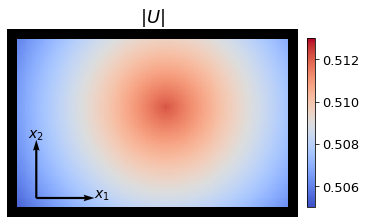

In [17]:
u_mag_true = (true_items['ux']**2 + true_items['uy']**2)**0.5
u_mag_true[mask] = np.nan

fig, ax = plt.subplots(1,1, figsize=[5.5, 3], constrained_layout=True)
cp = ax.pcolormesh(u_mag_true, cmap=cmap, vmin=0.505, vmax=0.513)
ax.set_title(r'$|U|$', weight='bold', fontsize=18)
ax.set_axis_off()
ax.set_aspect('equal')    

#formatter = mpl.ticker.ScalarFormatter(useOffset=0.501, useMathText=False)
#formatter.set_scientific('off')
#formatter.set_powerlimits((0,1))
cb = plt.colorbar(cp, pad=0.01, aspect=40, shrink=0.9)#, format=formatter)
cb.ax.tick_params(labelsize=13, rotation=0)

ax.quiver(0.1, 0.1, 0., 1, scale=5, color='k', transform=ax.transAxes)
ax.quiver(0.1, 0.1, 1., 0, scale=5, color='k', transform=ax.transAxes)
ax.text(0.3, 0.1, r'$x_1$', color='k', fontsize=14, transform=ax.transAxes)
ax.text(0.07, 0.42, r'$x_2$', color='k', fontsize=14, transform=ax.transAxes)
#cb.set_label(label=r'$u\,/\,a_0$', size=15, weight='bold', rotation=0)
plt.savefig('displacement_mag_true.pdf', bbox_inches='tight')
plt.show()


In [71]:
phase_cross_correlation(recons._rho_true[0], recons_direct['rho'][0])

(array([-2.,  0.]), 0.996731193372772, 0.6476668107390888)

In [ ]:
skimage.metrics.normalized_root_mse()

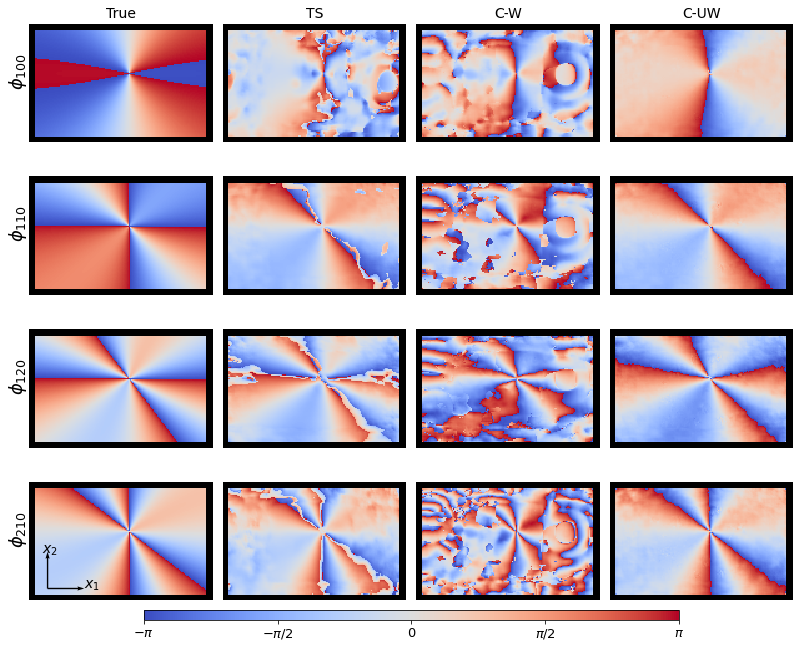

In [273]:
fig, axes = plt.subplots(4, 4, figsize=[11,9], constrained_layout=True)


for i, d in enumerate([true_items, recons_separate, recons_direct, recons_proj]):
    for j, ph in enumerate(['phi100', 'phi110', 'phi120', 'phi210']):
        if i == 0:
            rho_true = recons._rho_true[j]
            phi_this = np.angle(rho_true)
        else:
            rollr, errr, phaser = register_translation(rho_true[5:-5,5:-5], 
                                                       d['rho'][j][5:-5,5:-5], upsample_factor=10)
            rho_this = d['rho'][j] * np.exp(1j * phaser)
            phi_this = np.angle(rho_this)
            
        #recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        
        phi_this[mask] = np.nan
        cp = axes[j, i].pcolormesh(phi_this, cmap=cmap, vmin=-np.pi, vmax=np.pi)
        axes[j, i].set_axis_off()
        axes[j,i].set_aspect('equal')

axes[0, 0].set_title('True', fontsize=14)
axes[0, 1].set_title('TS', fontsize=14)
axes[0, 2].set_title('C-W', fontsize=14)
axes[0, 3].set_title('C-UW', fontsize=14)

axes[0, 0].text(-0.12, 0.5, r'$\phi_{100}$', fontsize=18, transform=axes[0, 0].transAxes, rotation=90)
axes[1, 0].text(-0.12, 0.5, r'$\phi_{110}$', fontsize=18, transform=axes[1, 0].transAxes, rotation=90)
axes[2, 0].text(-0.12, 0.5, r'$\phi_{120}$', fontsize=18, transform=axes[2, 0].transAxes, rotation=90)
axes[3, 0].text(-0.12, 0.5, r'$\phi_{210}$', fontsize=18, transform=axes[3, 0].transAxes, rotation=90)

axes[3, 0].quiver(0.1, 0.1, 0., 1, scale=5, color='k', transform=axes[3, 0].transAxes)
axes[3, 0].quiver(0.1, 0.1, 1., 0, scale=5, color='k', transform=axes[3, 0].transAxes)

axes[3, 0].text(0.3, 0.1, r'$x_1$', color='k', fontsize=14, transform=axes[3, 0].transAxes)
axes[3, 0].text(0.07, 0.4, r'$x_2$', color='k', fontsize=14, transform=axes[3, 0].transAxes)

cb = fig.colorbar(cp, ax=axes[:4, :4], ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                  shrink=0.7, location='bottom', aspect=30, pad=0.005)
cb.ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'0', r'$\pi/2$', r'$\pi$'])
cb.ax.tick_params(labelsize=13)

plt.savefig('phases.pdf', bbox_inches='tight')

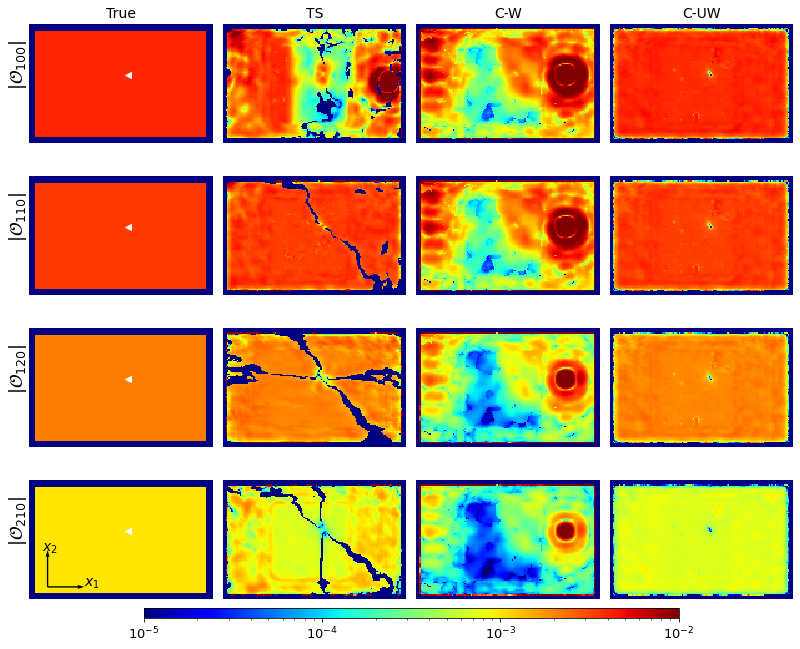

In [383]:
fig, axes = plt.subplots(4, 4, figsize=[11,9], constrained_layout=True)
for i, d in enumerate([true_items, recons_separate, recons_direct, recons_proj]):
    for j in range(4):
        if i == 0:
            rho_true = recons._rho_true[j]
            mag_this = np.abs(rho_true)
        else:
            mag_this = np.abs(d['rho'][j])
        
        mag_this[mag_this < 1e-5] = 1e-5
        #recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        #new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1.0)
        cp = axes[j, i].pcolormesh(mag_this, cmap='jet',
                            norm=LogNorm(vmin=1e-5, vmax=1e-2))
        #cp = axes[j, i].pcolormesh(mag_this, cmap=cmap)#, vmin=-np.pi, vmax=np.pi)
        axes[j, i].set_axis_off()
        axes[j,i].set_aspect('equal')

axes[0, 0].set_title('True', fontsize=14)
axes[0, 1].set_title('TS', fontsize=14)
axes[0, 2].set_title('C-W', fontsize=14)
axes[0, 3].set_title('C-UW', fontsize=14)

axes[0, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{100}|$', fontsize=18, transform=axes[0, 0].transAxes, rotation=90)
axes[1, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{110}|$', fontsize=18, transform=axes[1, 0].transAxes, rotation=90)
axes[2, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{120}|$', fontsize=18, transform=axes[2, 0].transAxes, rotation=90)
axes[3, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{210}|$', fontsize=18, transform=axes[3, 0].transAxes, rotation=90)

axes[3, 0].quiver(0.1, 0.1, 0., 1, scale=5, color='k', transform=axes[3, 0].transAxes)
axes[3, 0].quiver(0.1, 0.1, 1., 0, scale=5, color='k', transform=axes[3, 0].transAxes)

axes[3, 0].text(0.3, 0.1, r'$x_1$', color='k', fontsize=14, transform=axes[3, 0].transAxes)
axes[3, 0].text(0.07, 0.4, r'$x_2$', color='k', fontsize=14, transform=axes[3, 0].transAxes)

axes[0,0].plot(79, 54, "<w")
axes[1,0].plot(79, 54, "<w")
axes[2,0].plot(79, 54, "<w")
axes[3,0].plot(79, 54, "<w")

cb = fig.colorbar(cp, ax=axes[:4, :4], 
                  shrink=0.7, location='bottom', aspect=30, pad=0.005)
#cb.ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'0', r'$\pi/2$', r'$\pi$'])
cb.ax.tick_params(labelsize=13)

plt.savefig('magnitudes.pdf', bbox_inches='tight')

In [315]:
sm.sample.params.sample_pix_size

0.005841818181818182

In [325]:
for s in sm.simulations_per_peak:
    print(s.diffraction_patterns.max())

83
65
52
12
